# Deep Learning for Computer Vision:  Assignment 1


## Computer Science: COMS W 4995 006


### Due: February 13, 2018

#### Problem 1

You are asked to produce a minumum error rate classifier for a 3-class classification problem. Your feature space is 2-dimensional. Let's say the class conditional density functions (or likelihoods) are known and given by $\rho({\bf x}|y_i)$
where ${\bf x}$ is your feature and $y_i$ specifies the class. Let's also assume that the priors $P(y_i)$ are also given. (Both of these are specified below.) Show the decision regions for each of the three classes. Hint: you can show this by densely generating sample points ${\bf x}_j \in X$ in the feature space, classifying them, and then plotting and coloring them according to their predicted label.

Let the ccds and priors be given as:
    

$$\rho({\bf x}|y_1) \sim N({\bf \mu}_1, \Sigma_1)  \text{ and } P(y_1) = 0.5\,\, \text{ where } \,\, 
{\bf \mu}_1 = \left[\begin{array}{c} 1 \\ 1  \end{array} \right]
\,\, \text{ and } 
\Sigma_1 = \left[\begin{array}{cc} 1 & 0 \\ 0 & 0.5  \end{array} \right] $$


#### $$\rho({\bf x}|y_2) \sim N({\bf \mu}_2, \Sigma_2)  \text{ and } P(y_2) = 0.4\,\, \text{ where } \,\, 
{\bf \mu}_2 = \left[\begin{array}{c} 1 \\ 0  \end{array} \right]
\,\, \text{ and } 
\Sigma_2 = \left[\begin{array}{cc} 0.5 & 0 \\ 0 & 1  \end{array} \right] $$


$$\rho({\bf x}|y_3) \sim N({\bf \mu}_3, \Sigma_3)  \text{ and } P(y_3) = 0.1\,\, \text{ where } \,\, 
{\bf \mu}_3 = \left[\begin{array}{c} 0 \\ -1  \end{array} \right]
\,\, \text{ and } 
\Sigma_3 = \left[\begin{array}{cc} 2.0 & 0 \\ 0 & 0.5  \end{array} \right] $$

Remember all you need to do is to use Bayes theorem to get the expression for $P(y_i|{\bf x})$, then for each sample ${\bf x}_j \in X$ choose the $i$ with the highest aposteriori probability. Do not use any statisical packages to do this other than numpy.

In [176]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

In [177]:
num_samples = 1000
num_classes = 3
feature_dims = 2
total_samples = num_samples*num_classes
priors = np.array([0.5, 0.4, 0.1])
means = np.array([[1, 1], [1, 0], [0, -1]])
covariances = np.array([
    [[1, 0], 
     [0, 0.5]],
    [[0.5, 0], 
     [0, 1]],
    [[2, 0], 
     [0, 0.5]]
])

In [178]:
def compute_likelihood(data, mean, cov):
    likelihood = np.empty((data.shape[0], 1))
    likelihood = 1.0/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    pdf = np.dot(data - mean, np.linalg.inv(cov))
    pdf = np.dot(pdf, (data - mean).T)
    pdf = np.diag(np.exp(-0.5 * pdf))
    likelihood = likelihood * pdf
    return likelihood

In [179]:
def predict(data, evidence):
    posteriors = np.empty((num_classes, data.shape[0]))
    for i in range(num_classes):
        posteriors[i, ::] = compute_likelihood(data, means[i], covariances[i, :]) * priors[i] / evidence
    return np.argmax(posteriors, axis = 0)

In [190]:
# Sloppy function for plotting our data
def plot_data(X, y, title):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], 'r', marker='o', linestyle='', ms=5, label='Class 0')
    ax.plot(X[indices_1, 0], X[indices_1,1], 'b', marker='o', linestyle='', ms=5, label='Class 1')
    ax.plot(X[indices_2, 0], X[indices_2,1], 'g', marker='o', linestyle='', ms=5, label='Class 2') 

    matplotlib.rcParams.update({'font.size': 16})
    ax.legend()
    ax.legend(loc = 2)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(title, **{'size':18})
    plt.show()

In [185]:
data = np.empty((total_samples, feature_dims))
labels = np.empty((total_samples, 1))
likelihoods = np.zeros((total_samples, 1))
evidence = 0
for class_i in range(num_classes):
    class_idx = np.arange(class_i*num_samples, (class_i + 1)* num_samples)
    data_samples = \
        np.random.multivariate_normal(means[class_i], covariances[class_i], num_samples)
    data[class_idx, :] = data_samples
    labels[class_idx, :] = class_i
    likelihoods[class_idx, 0] = compute_likelihood(data[class_idx, :], means[class_i], covariances[class_i, :])
    evidence += np.sum(likelihoods[class_idx, 0] * priors[class_i])
    
predicted_labels = predict(data, evidence)

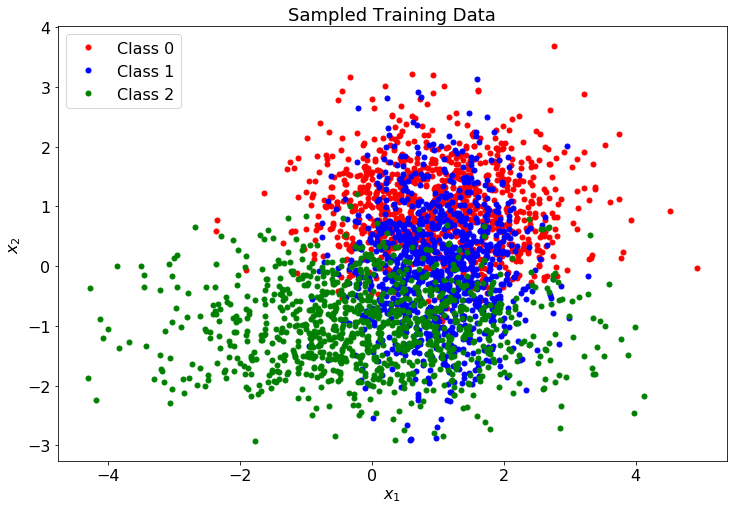

In [191]:
plot_data(data, labels, "Sampled Training Data")

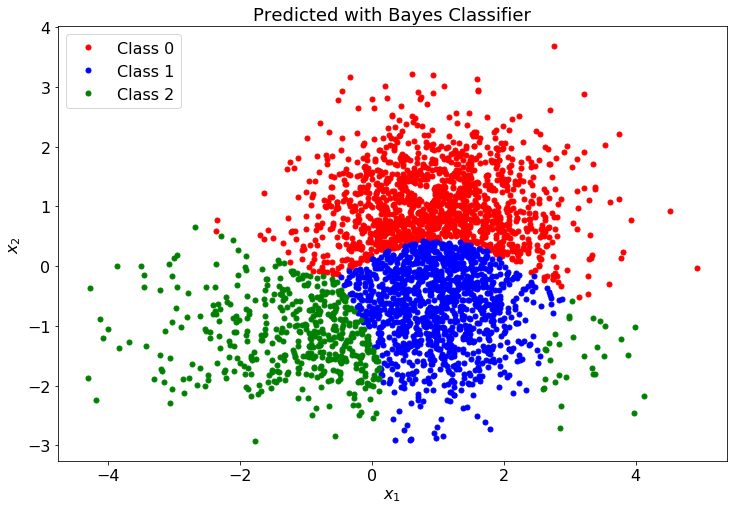

In [192]:
plot_data(data, predicted_labels, "Predicted with Bayes Classifier")

#### Problem 2

Implement the Pegasos algorithm for finding a linear SVM classifier which separates the training data generated below. Experiment with three different choices for the regularization parameter and plot the resulting separating plane. Explain how the choice of C effects the resulting solution. Hint: the algorithm might show better convergence if you use the projection normalization step. Also, you can consult with any literature beyond the course notes, but you must write your own code.

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Let's make up some random data to use to build our SVM classifier
data = pd.DataFrame(np.zeros((500, 3)), columns=['x1', 'x2', 'y'])

for i in range(len(data.index)):
    x1 = random.randint(20,100)
    if np.random.random() > 0.5:
        data.iloc[i,0] = 1.0 * x1 
        data.iloc[i,1] = 0.25 * x1 + 50.0 * (random.random() - 0.5) + 65.0
        data.iloc[i,2] = 1.0
    else:
        data.iloc[i,0] = 1.0 * x1
        data.iloc[i,1] = 0.24 * x1 + 50.0 * (random.random() - 0.5) + 0.0 
        data.iloc[i,2] = -1.0
    
# Add in a stray point
data.iloc[0,0] = 50.0
data.iloc[0,1] = 0.25 * x1 + 25.0
data.iloc[0,2] = 1.0

# Now let's normalize this data.

data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()

data.head()
data.describe()

,x1,x2,y
count,5.000000e+02,5.000000e+02,500.000000
mean,-1.385558e-16,-1.705303e-16,-0.008000
std,1.000000e+00,1.000000e+00,1.000969
min,-1.711016e+00,-1.790556e+00,-1.000000
25%,-8.410226e-01,-8.886342e-01,-1.000000
50%,2.897078e-02,-5.357701e-03,-1.000000
75%,8.554645e-01,8.596256e-01,1.000000
max,1.768958e+00,1.852087e+00,1.000000


In [4]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)

In [5]:
# Sloppy function for plotting our data
def plot_data(X, y):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y > 0
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='-1')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Training Data')
    plt.show()

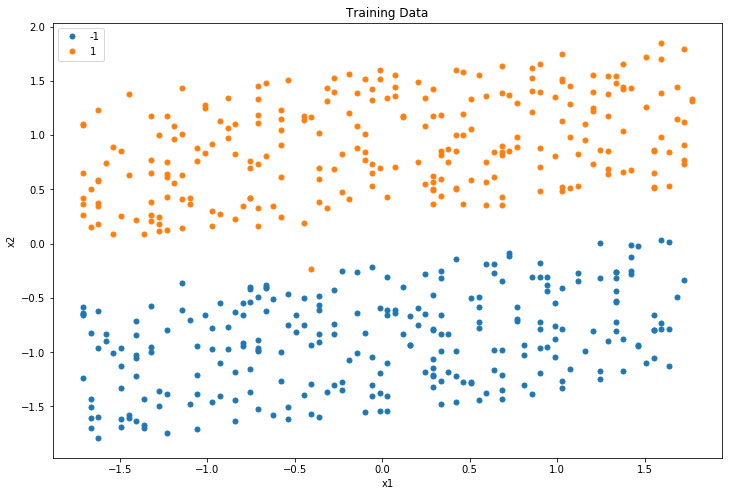

In [6]:
plot_data(X,y)